In [1]:
import numpy as np
import pandas as pd

dtype = {
    'id': np.int8,
    'qid1': np.int8,
    'qid2': np.int8,
    'question1': np.str,
    'question2': np.str,
    'is_duplicate': np.int8
}
train = pd.read_csv('/input/Kaggle/Quora/train.csv', dtype=dtype)
print(train.shape)
train.dropna(inplace=True)
print(train.shape)

In [ ]:
dtype = {
    'test_id': np.int8,
    'question1': np.str,
    'question2': np.str
}
test = pd.read_csv('/input/Kaggle/Quora/test.csv', dtype=dtype)
print( (test.isnull()).sum().sum() )
test.replace(np.nan, '', inplace=True)
print( (test.isnull()).sum().sum() )

In [6]:
unique_questions = pd.concat([train.question1, train.question2]).unique()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.snowball import EnglishStemmer

count_analyzer = CountVectorizer().build_analyzer()
tfidf_analyzer = TfidfVectorizer().build_analyzer()
stemmer = EnglishStemmer()

def stem_count_analyzer(doc):
    return (stemmer.stem(w) for w in count_analyzer(doc))
def stem_tfidf_analyzer(doc):
    return (stemmer.stem(w) for w in tfidf_analyzer(doc))

cv = CountVectorizer(analyzer=stem_count_analyzer, stop_words='english', max_features=128)
tv = CountVectorizer(analyzer=stem_tfidf_analyzer, stop_words='english', max_features=128)

cv.fit(unique_questions)
tv.fit(unique_questions)

q1_cv = cv.transform(train.question1)
q2_cv = cv.transform(train.question2)

q1_tv = tv.transform(train.question1)
q2_tv = tv.transform(train.question2)

In [177]:
S = 1000

if True:
    q1_cv_p = q1_cv[:S].toarray()
    q2_cv_p = q2_cv[:S].toarray()
    q1_tv_p = q1_tv[:S].toarray()
    q2_tv_p = q2_tv[:S].toarray()
else:
    q1_cv_p = q1_cv.toarray()
    q2_cv_p = q2_cv.toarray()
    q1_tv_p = q1_tv.toarray()
    q2_tv_p = q2_tv.toarray()

In [155]:
# 共同出现的词语个数/所有词语个数
inter_cv = q1_cv_p & q2_cv_p
union = q1_cv_p | q2_cv_p
cover_ratio = inter_cv.sum(axis=1) / union.sum(axis=1)

In [ ]:
# 共同出现的词语次数/所有词语总个数
q12_cv_p = q1_cv_p + q2_cv_p
occur_num = [tup[np.where(idx)].sum() for idx, tup in zip(inter_cv, q12_cv_p)]
occur_ratio = occur_num / q12_cv_p.sum(axis=1)

In [178]:
# TFIDF weight公共部分/TFIDF总weight
inter_tv = q1_tv_p & q2_tv_p
q12_tv_p = q1_tv_p + q2_tv_p
inter_weight = [tup[np.where(idx)].sum() for idx, tup in zip(inter_tv, q12_tv_p)]
tfidf_ratio = inter_weight / q12_tv_p.sum(axis=1)

In [239]:
from sklearn.preprocessing import StandardScaler

X_all = DataFrame({
    'cover_ratio': cover_ratio,
    'occur_ratio': occur_ratio,
    'tfidf_ratio': tfidf_ratio
})
X_all_std = StandardScaler().fit_transform(X_all)
y_all = train.is_duplicate[:S]

In [242]:
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression()
grid = {
    'C': [0.3, 1, 3, 7, 10, 15, 20, 25, 30],
    'penalty': ['l1', 'l2']
}
cv = GridSearchCV(lr, grid, scoring='neg_log_loss', n_jobs=-1, verbose=1)
cv.fit(X_all_std, y_all)
cv.best_params_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    0.2s finished


{'C': 15, 'penalty': 'l2'}

In [243]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr = LogisticRegression(C=15, penalty='l2')

log_loss = -cross_val_score(lr, X_all_std, y_all, scoring='neg_log_loss').mean()
accuracy = cross_val_score(lr, X_all_std, y_all).mean()

print("log_loss:{:.4f} accuracy:{:.4f}".format(log_loss, accuracy))

log_loss:0.5778 accuracy:0.6580


In [249]:
from sklearn.ensemble import GradientBoostingClassifier

log_loss = -cross_val_score(GradientBoostingClassifier(), X_all_std, y_all, scoring='neg_log_loss').mean()
accuracy = cross_val_score(GradientBoostingClassifier(), X_all_std, y_all).mean()

print("log_loss:{:.4f} accuracy:{:.4f}".format(log_loss, accuracy))

log_loss:0.6003 accuracy:0.6391


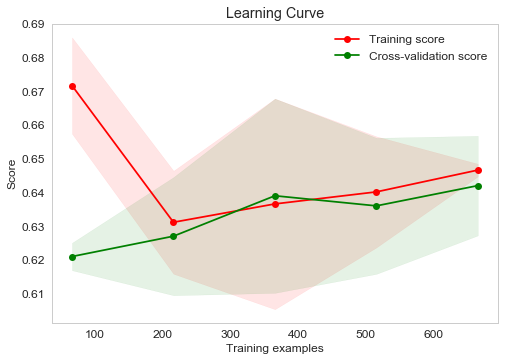

In [250]:
from scikitplot import plotters as skplt
skplt.plot_learning_curve(lr, X_all, y_all)
plt.show()

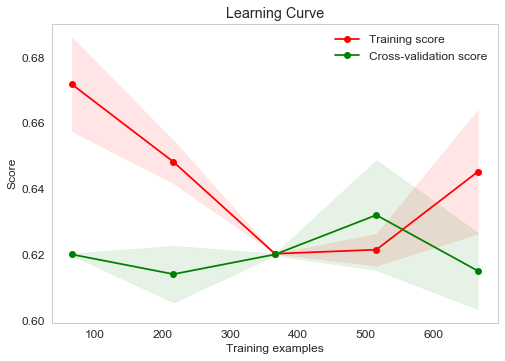

In [245]:
from sklearn.svm import SVC
skplt.plot_learning_curve(SVC(), X_all, y_all)
plt.show()

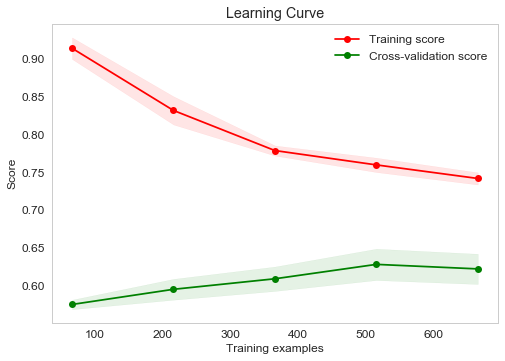

In [246]:
from sklearn.ensemble import RandomForestClassifier
skplt.plot_learning_curve(RandomForestClassifier(), X_all, y_all)
plt.show()

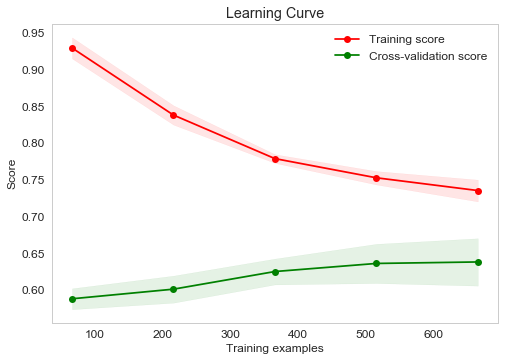

In [247]:
from sklearn.ensemble import GradientBoostingClassifier
skplt.plot_learning_curve(GradientBoostingClassifier(), X_all, y_all)
plt.show()